In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import stardate as sd
import emcee
# from stardate.lhf import calc_bv, gyro_model_rossby, gyro_model

from isochrones import StarModel, get_ichrone
bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = get_ichrone("mist", bands=bands)

Plot the lhf for a range of parameters for one of the simulated stars.

In [321]:
df = pd.read_csv("data/simulated_data.csv")
df = df.iloc[0]


fname = "0000_stardate.h5"
reader = emcee.backends.HDFBackend(fname)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()

In [322]:
teff_err = 25  # Kelvin
logg_err = .05  # dex
feh_err = .05  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
B_err, V_err, bp_err, rp_err = .01, .01, .01, .01
parallax_err = .05  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

# Set up the parameter dictionary.
iso_params = {"teff": (df["teff"], teff_err),
              "logg": (df["logg"], logg_err),
              "feh": (df["feh"], feh_err),
              "J": (df["jmag"], jmag_err),
              "H": (df["hmag"], hmag_err),
              "K": (df["kmag"], kmag_err),
              "B": (df["B"], B_err),
              "V": (df["V"], V_err),
              "G": (df["G"], bp_err),
              "BP": (df["BP"], bp_err),
              "RP": (df["RP"], rp_err),
              "parallax": (df["parallax"], parallax_err),
              "maxAV": .1}

mod = StarModel(mist, **iso_params)
args = [mod, df.prot, df.prot_err, None, None, False, False]  # the lnprob arguments]

lnparams = [df.eep, df.age, df.feh, np.log(df.d_kpc*1e3), df.Av]

from stardate.lhf import lnprob
# results = [435.85329441431645, 10.129259535998095, 0.33433233038395804, 6.016792599385651, 0.09578287162914803]  #69
# results = [443.4654382454131, 10.10951671752959, 0.07585148249477253, 6.852824639667813, 0.006064535155196636]  # 74
# results = np.array(results)

# inits = [466.442179691302, 9.783143924615793 ,0.04437935597266553 ,6.582800220670122 ,0.05112581468906065]  # 69
# inits = [442.3273995248113, 10.059660590480487, 0.14836682399774623, 6.885960128515226, 0.0017892251734095686]  # 74
# inits = np.array(inits)

print("truth = ", lnprob(lnparams, *args))
print("MCMC result = ", lnprob(results, *args))
print("inits = ", lnprob(inits, *args))

truth =  (-14.307167259432173, -16.30196905667401)
MCMC result =  (-160235.1527626439, -16.165816913737086)
inits =  (-160947.32019054017, -16.44975039451458)


In [323]:
age_probs, age_iso_probs = [], []
iso_args = [mod, None, None, None, None, True, False]
ages = np.linspace(8.8, 10.14, 1000)
for i in range(1000):
    lnparams = [df.eep, ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
    age_probs.append(lnprob(lnparams, *args)[0])
    age_iso_probs.append(lnprob(lnparams, *iso_args)[0])

2.999294539321365


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


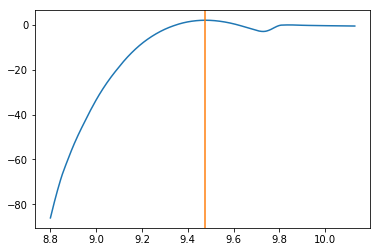

In [324]:
plt.plot(ages, np.array(age_probs)-np.array(age_iso_probs))
# plt.plot(ages, iso_probs)
plt.axvline(df.age, color="C1")
# plt.axvline(results[1], color="C2")
print((10**df.age)*1e-9)

In [325]:
eep_probs, eep_iso_probs = [], []
eeps = np.linspace(250, 550, 1000)
for i in range(1000):
    lnparams = [eeps[i], df.age, df.feh, np.log(df.d_kpc*1e3), df.Av]
    eep_probs.append(lnprob(lnparams, *args)[0])
    eep_iso_probs.append(lnprob(lnparams, *iso_args)[0])

301.7439338714983


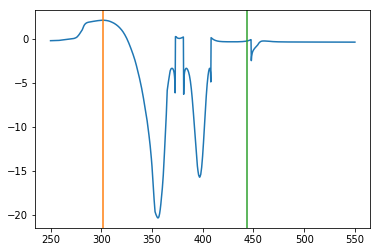

In [326]:
plt.plot(eeps, np.array(eep_probs) - np.array(eep_iso_probs))
plt.axvline(df.eep, color="C1")
plt.axvline(results[0], color="C2")
print(df.eep)

In [327]:
from tqdm import trange
nage, neep = 90, 110
ages = np.linspace(8.8, 10.14, nage)
eeps = np.linspace(250, 550, neep)

probs = np.zeros((nage, neep))
A, E = np.meshgrid(ages, eeps, indexing="ij")
for i in trange(nage):
    for j in range(neep):
        lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
        probs[i, j] = lnprob(lnparams, *args)[0]

100%|██████████| 90/90 [00:04<00:00, 21.07it/s]


In [328]:
iso_probs = np.zeros((nage, neep))
for i in trange(nage):
    for j in range(neep):
        lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
        iso_probs[i, j] = lnprob(lnparams, *iso_args)[0]

100%|██████████| 90/90 [00:03<00:00, 28.79it/s]


443.4654382454131 10.10951671752959
10.10951671752959
[10.10988764]
[87]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


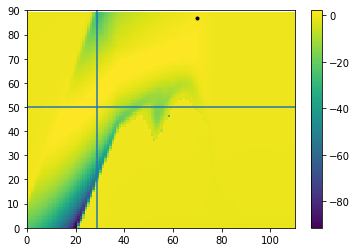

In [329]:
fig, ax = plt.subplots()
im = ax.pcolormesh(probs - iso_probs)
# plt.plot(30, 88, "w.")
ylabels, xlabels = [], []
for i in range(9):
    ylabels.append("{0:.2f}".format((10**ages[::10][i])*1e-9))
for i in range(11):
    xlabels.append("{0:.2f}".format(eeps[::10][i]))
# ax.set_xticklabels(xlabels);
# ax.set_yticklabels(ylabels);

print(results[0], results[1])
# m = (results[0] - 2 < eeps) * (eeps < results[0] + 2)
m = (results[1] - .01 < ages) * (ages < results[1] + .01)
print(results[1])
print(ages[m])
print(np.arange(nage)[m])

plt.axhline(50)
plt.axvline(29)
fig.colorbar(im, ax=ax)
plt.plot(70, 87, "k.")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'EEP')

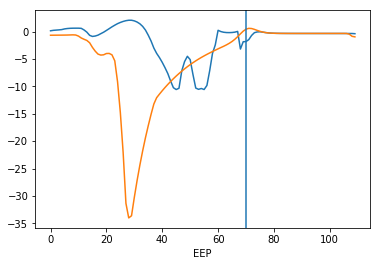

In [311]:
diff = probs - iso_probs
plt.plot(np.arange(110), diff[50, :])
plt.plot(np.arange(110), diff[87, :])
plt.axvline(70)
plt.xlabel("EEP")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Age')

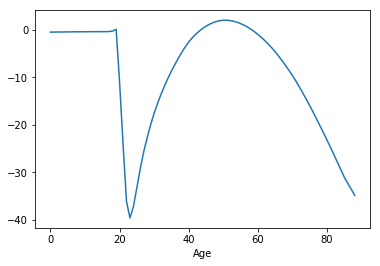

In [312]:
diff = probs - iso_probs
plt.plot(np.arange(90), diff[:, 29])
plt.xlabel("Age")

In [337]:
def make_l_plot(df):
    print(df.eep, df.age)
    
    # Set up the parameter dictionary.
    iso_params = {"teff": (df["teff"], teff_err),
                  "logg": (df["logg"], logg_err),
                  "feh": (df["feh"], feh_err),
                  "J": (df["jmag"], jmag_err),
                  "H": (df["hmag"], hmag_err),
                  "K": (df["kmag"], kmag_err),
                  "B": (df["B"], B_err),
                  "V": (df["V"], V_err),
                  "G": (df["G"], bp_err),
                  "BP": (df["BP"], bp_err),
                  "RP": (df["RP"], rp_err),
                  "parallax": (df["parallax"], parallax_err),
                  "maxAV": .1}

    mod = StarModel(mist, **iso_params)
    args = [mod, df.prot, df.prot_err, None, None, False, False]  # the lnprob arguments]

    probs = np.zeros((nage, neep))
    for i in trange(nage):
        for j in range(neep):
            lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
            probs[i, j] = lnprob(lnparams, *args)[0]
        
    iso_probs = np.zeros((nage, neep))
    for i in trange(nage):
        for j in range(neep):
            lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
            iso_probs[i, j] = lnprob(lnparams, *iso_args)[0]
        
    fig, ax = plt.subplots()
    im = ax.pcolormesh(probs - iso_probs)

  0%|          | 0/90 [00:00<?, ?it/s]/Users/rangus/projects/stardate/stardate/lhf.py:118: RuntimeWarning: invalid value encountered in double_scalars
  age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
  2%|▏         | 2/90 [00:00<00:05, 17.32it/s]

465.9535773268261 9.892965813278296


100%|██████████| 90/90 [00:03<00:00, 28.37it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


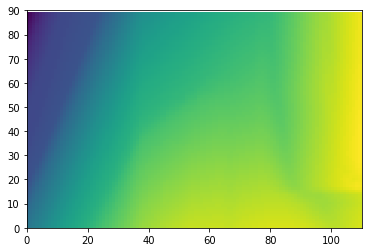

In [338]:
df = pd.read_csv("data/simulated_data.csv")
make_l_plot(df.iloc[1])

  2%|▏         | 2/90 [00:00<00:05, 17.32it/s]

301.7439338714983 9.477019116816836


100%|██████████| 90/90 [00:03<00:00, 28.06it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


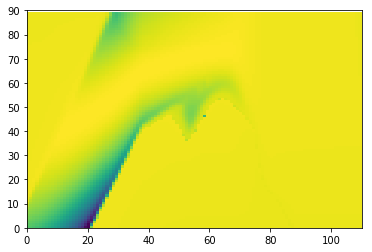

In [339]:
make_l_plot(df.iloc[0])

  2%|▏         | 2/90 [00:00<00:05, 17.48it/s]

403.61827341625036 10.089366986893923


100%|██████████| 90/90 [00:03<00:00, 28.19it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


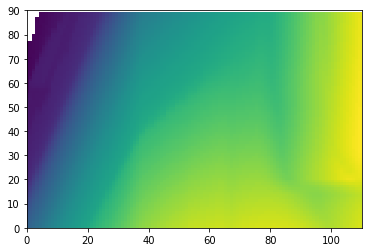

In [340]:
make_l_plot(df.iloc[2])

  2%|▏         | 2/90 [00:00<00:04, 17.62it/s]

365.6176679961554 10.016408004967225


100%|██████████| 90/90 [00:03<00:00, 24.87it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


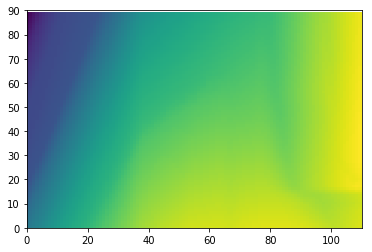

In [341]:
make_l_plot(df.iloc[3])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


ValueError: x and y must have same first dimension, but have shapes (1000,) and (90,)

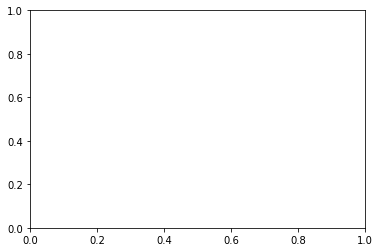

In [313]:
plt.plot(np.array(age_probs)-np.array(age_iso_probs), ages)
# plt.plot(ages, iso_probs)
plt.axhline(df.age, color="C1")
plt.axhline(results[1], color="C2")

In [ ]:
plt.plot(eeps, np.array(eep_probs) - np.array(eep_iso_probs))
plt.axvline(df.eep, color="C1")
plt.axvline(results[0], color="C2")
print(df.eep)

We're going to explore what the likelihood function looks like.

In [562]:
def convective_overturn_time(*args):
    """Estimate the convective overturn time.

    Estimate the convective overturn time using equation 11 in Wright et al.
    (2011): https://arxiv.org/abs/1109.4634
    log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)

    Args:
        args: EITHER mass (float): Mass in Solar units OR eep (float):
            The Equivalent evolutionary point of a star (355 for the Sun),
            age (float): The age of a star in log_10(years) and feh (float):
            the metallicity of a star.

    Returns:
        The convective overturn time in days.

    """

    if len(args) > 1:
        # Convert eep, age and feh to mass (mass will be in Solar mass units)
        eep, age, feh = args
        M = mist.interp_value([eep, age, feh], ["mass"])
    else:
        M = args[0]

    log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
    return 10**log_tau


def calc_bprp(mag_pars):
    """Calculate a G_bp-G_rp colour from stellar parameters.

    Calculate bp-rp colour from stellar parameters [EEP, log10(age, yrs), feh,
    distance (in parsecs) and extinction] using MIST isochrones.

    Args:
        mag_pars (list): A list containing EEP, log10(age) in years,
            metallicity, distance in parsecs and V-band extinction, Av, for a
            star.

    Returns:
        G_bp - G_rp color.

    """
    _, _, _, bands = mist.interp_mag([*mag_pars], ["BP", "RP"])
    bp, rp = bands
    return bp - rp

Define the new gyro model.

In [832]:
def period_model(params, log10_bprp, log10_age):
    """
    Predicts log10 rotation period from log10 color and log10 age.
    
    Args:
        params (list): The list of model parameters.
        log10_bprp (array): The (log10) G_bp - G_rp color array.
        log10_age (array): The (log10) age array.
    Returns:
        log10_period (array): The (log10) period array.
    """
    return np.polyval(params[:20], log10_bprp) + params[20]*log10_age


def age_model(params, log10_bprp, log10_period):
    """
    Predicts log10 age from log10 color and log10 period.
    
    Args:
        params (list): The list of model parameters.
        log10_bprp (array): The (log10) G_bp - G_rp color array.
        log10_period (array): The (log10) period array.
    Returns:
        log10_age (array): The (log10) age  array.
    """
    return (log10_period - np.polyval(params[:20], log10_bprp))/params[20]

def variance(p, log10_bprp, eep, log10_period_err):
    z = eep/100.
    return (log10_period_err + np.polyval(p[21:24], log10_bprp) + np.polyval(p[24:], z))**2

# Test these models with Solar values
# par = [-368.45643784860033, 695.3279793519738, 396.7318187948002,
#               -913.8941676968989, -4.285360945342232, -633.8313260304885,
#               375.86156815716527, 872.4274283682225, -59.29022811073145,
#               803.7883055633133, -1179.9434901842233, -1297.5846247255904,
#               1230.0129533662775, 559.6239203031654, -443.7932574323561,
#               -83.31481638850344, 51.160545174146954, -2.428588637483325,
#               0.674925166060539, -5.313426891558643, 0.7081072443768881,
#               3.547556067649739, -0.03403261258090268, -3.43848152145279,
#               0.3482138491369073, -2.8831675822407044, 7.8290170310554705,
#               -3.4384815148170618]
par = [-259.0032323279751, 472.26489845762046, 371.0117430563085, -615.7196717247617, -284.34293420557333, -527.3789562697561, 498.61612731908076, 819.3205304747509, 218.90566286693826, 345.2188283025659, -1524.5858717675835, -809.0223594310723, 1428.2095670063745, 370.07665359629175, -509.7921986825753, -51.450261122177245, 60.51717952536289, -4.4287343334913425, 0.4471274129474507, -4.8439199640496104, 0.659426476518618, 3.33182965988879, -0.15831741828932977, -7.3404869270385795, 0.5852938997336767, -5.309162205264913, 15.605683405942848, -7.340459976644295]

print(10**period_model(par, np.log10(.82), np.log10(4.56*1e9)))
print((10**age_model(par, np.log10(.82), np.log10(26)))*1e-9)

25.999556790769724
4.560117880841045


[25.99955679]
[31.15735751]
[31.22149905]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Prot')

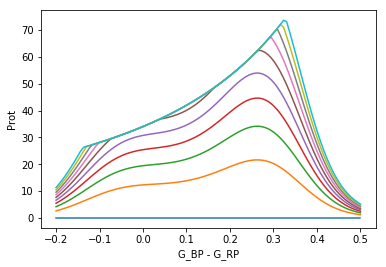

In [833]:
def gyro_model_rossby(params, log10_age, log10_bprp, mass, Ro_cutoff=2.16, rossby=True):
    """Predict a rotation period from an age, B-V colour and mass.

    Predict a rotation period from an age, B-V color and mass using a gyrochronology 
    model fit to the Praesepe cluster and the Sun with the van Saders et al. (2016)
    weakened magnetic braking correction.

    Args:
        log10_age (array): The log10_ages of stars in years.
        log10_bprp (array): The log10 G_BP - G_RP color of stars.
        mass (array): The mass of stars in Solar masses.
        Ro_cutoff (float, optional): The critical Rossby number after which
            stars retain their rotation period. This is 2.16 in van Saders et
            al. (2016) and 2.08 in van Saders et al. (2018). We adopt a
            default value of 2.16.
        rossby (Optional[bool]): If True (default), the van Saders (2016)
            weakened magnetic braking law will be implemented.

    Returns:
        prot (array): The rotation periods in days.
    """
    
    log_P = period_model(params, log10_bprp, log10_age)
    
    if not rossby:  # If Rossby model is switched off
        return log_P

    # Otherwise the Rossby model is switched on.
    # Calculate the maximum theoretical rotation period for this mass.
    pmax = Ro_cutoff * convective_overturn_time(mass)

    # Calculate the age at which this star reaches pmax, based on its bp-rp color.
    log10_age_thresh = age_model(params, log10_bprp, np.log10(pmax))

    # If star older than this age, return maximum possible rotation period.
    old = log10_age > log10_age_thresh
    if len(old) == 1 and old[0] == True:
        return np.log10(pmax)
    elif len(old) == 1 and old[0] == False:
        return log_P
        
    else:
        log_P[old] = np.log10(pmax[old])
        return log_P
        
# Test this model.
print(10**gyro_model_rossby(par, np.array([np.log10(4.56*1e9)]), np.log10(.82), np.array([1.])))
print(10**gyro_model_rossby(par, np.array([np.log10(6*1e9)]), np.log10(.82), np.array([1.])))
print(10**gyro_model_rossby(par, np.array([np.log10(9*1e9)]), np.log10(.82), np.array([1.])))

plot_bprp = np.linspace(-.2, .5, 100)
plot_mass = np.linspace(1.2, .3, 100)

for age in range(10):
    plt.plot(plot_bprp, 10**gyro_model_rossby(par, np.array([np.log10(age*1e9)]), plot_bprp, plot_mass))
    
plt.xlabel("G_BP - G_RP")
plt.ylabel("Prot")

In [840]:
def lnprob(lnparams, *args):
    params = lnparams*1
    params[3] = np.exp(lnparams[3])
    params = [float(p) for p in params]

    mod, period, period_err, _, _, _, _ = args

    log10_bprp = np.log10(calc_bprp(params))
    if not np.isfinite(log10_bprp):
        return mod.lnlike(params), -np.inf, mod.lnprior(params)
        
    mass = mist.interp_value([params[0], params[1], params[2]], ["mass"])
    
    # Praesepe model parameters. These model parameters were fit to
    # log10(age), log10(period), log10(G_BP - G_RP) and EEP
#     p = [-368.45643784860033, 695.3279793519738, 396.7318187948002,
#          -913.8941676968989, -4.285360945342232, -633.8313260304885,
#          375.86156815716527, 872.4274283682225, -59.29022811073145,
#          803.7883055633133, -1179.9434901842233, -1297.5846247255904,
#          1230.0129533662775, 559.6239203031654, -443.7932574323561,
#          -83.31481638850344, 51.160545174146954, -2.428588637483325,
#          0.674925166060539, -5.313426891558643, 0.7081072443768881,
#          3.547556067649739, -0.03403261258090268, -3.43848152145279,
#          0.3482138491369073, -2.8831675822407044, 7.8290170310554705,
#          -3.4384815148170618]
    
    p = [-259.0032323279751, 472.26489845762046, 371.0117430563085, -615.7196717247617, -284.34293420557333, -527.3789562697561, 498.61612731908076, 819.3205304747509, 218.90566286693826, 345.2188283025659, -1524.5858717675835, -809.0223594310723, 1428.2095670063745, 370.07665359629175, -509.7921986825753, -51.450261122177245, 60.51717952536289, -4.4287343334913425, 0.4471274129474507, -4.8439199640496104, 0.659426476518618, 3.33182965988879, -0.15831741828932977, -7.3404869270385795, 0.5852938997336767, -5.309162205264913, 15.605683405942848, -7.340459976644295]
    
    log10_period_model = gyro_model_rossby(p, params[1], log10_bprp, mass)
#     var = (np.log10(period_err)/np.log10(period))**2
#     var = (period_err/period)**2
#     var = (period_err/period * np.log10(period))**2
#     print("small", np.mean(var))
    var = variance(p, log10_bprp, params[0], period_err/period*np.log10(period))*1e-1
#     print("large", np.mean(var))
    gyro_lnlike = np.sum(-.5*((log10_period_model - np.log10(period))**2/var) - .5*np.log(2*np.pi*var))
    
    return mod.lnlike(params), gyro_lnlike, mod.lnprior(params)

In [841]:
full_df = pd.read_csv("data/simulated_data.csv")
ind = 11
df = full_df.iloc[ind]

In [842]:
teff_err, logg_err, feh_err = 25, .05, .05
jerr, herr, kerr = .01, .01, .01
plx_err, prot_err, BV_err = .05, 1, .01

iso_params = {"teff": (df["teff"], teff_err),
             "logg": (df["logg"], logg_err),
             "feh": (df["feh"], feh_err),
             "J": (df["jmag"], jerr),
             "H": (df["hmag"], herr),
             "K": (df["kmag"], kerr),
             "parallax": (df["parallax"], plx_err),
             "maxAV": .1}

mod = StarModel(mist, **iso_params)
args = [mod, df["prot"], .01, None, None, False, False]  # the lnprob arguments
params = [df["eep"], df["age"], df["feh"], df["d_kpc"]*1e3, df["Av"]]
lnparams = [df["eep"], df["age"], df["feh"], np.log(df["d_kpc"]*1e3), df["Av"]]

Plot this star alongside the model.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


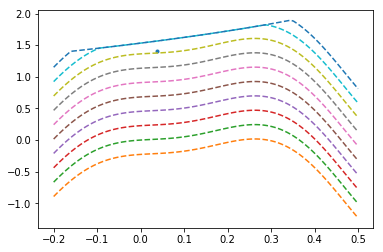

In [843]:
bprp = calc_bprp(params)
plt.plot(np.log10(bprp), np.log10(df["prot"]), ".")
plot_bprp = np.linspace(-.2, .5, 100)

for a in np.linspace(7, 10.1, 10.):
    plt.plot(plot_bprp, gyro_model_rossby(par, a, plot_bprp, plot_mass), ls="--")

# EEP

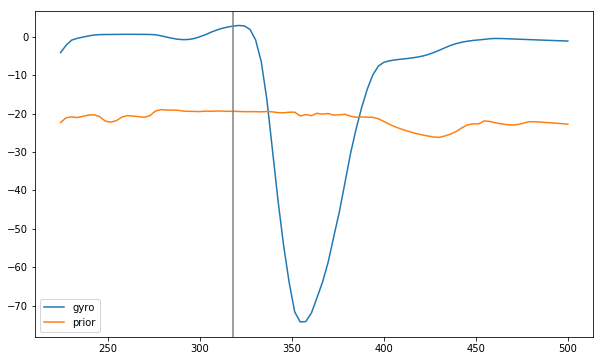

In [845]:
N = 100
eeps = np.linspace(200, 500, N)
age, feh, dis, av = df.age, df.feh, np.log(df.d_kpc*1e3), df.Av
iso, gyro, prior = [np.empty(N) for i in range(3)]
for i in range(N):
    lnparams = [eeps[i], age, feh, dis, av]
    _iso, _gyro, _prior = lnprob(lnparams, *args)
    iso[i] = _iso
    gyro[i] = _gyro
    prior[i] = _prior
    
plt.figure(figsize=(10, 6))
# plt.plot(eeps, iso, label="iso")
plt.plot(eeps, gyro, label="gyro")
plt.plot(eeps, prior, label="prior")
plt.axvline(df.eep, color=".5")
plt.legend()

# Age

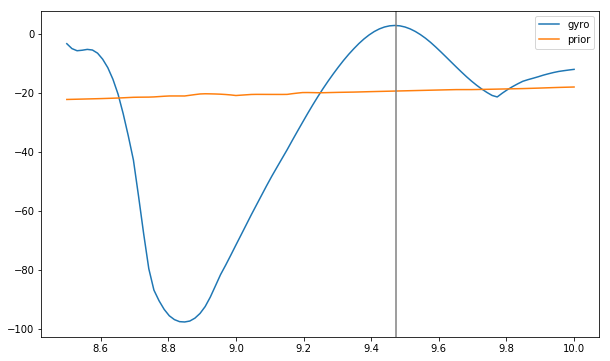

In [847]:
N = 100
ages = np.linspace(8.5, 10, N)
eep, feh, dis, av = df.eep, df.feh, np.log(df.d_kpc*1e3), df.Av
iso, gyro, prior = [np.empty(N) for i in range(3)]
for i in range(N):
    lnparams = [eep, ages[i], feh, dis, av]
    _iso, _gyro, _prior = lnprob(lnparams, *args)
    iso[i] = _iso
    gyro[i] = _gyro
    prior[i] = _prior
    
plt.figure(figsize=(10, 6))
# plt.plot(ages, iso, label="iso")
plt.plot(ages, gyro, label="gyro")
plt.plot(ages, prior, label="prior")
plt.axvline(df.age, color=".5")
plt.legend()

# [Fe/H]

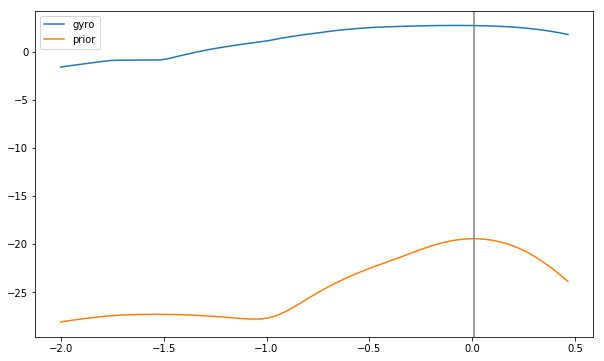

In [849]:
N = 100
fehs = np.linspace(-2, 2, N)
eep, age, dis, av = df.eep, df.age, np.log(df.d_kpc*1e3), df.Av
iso, gyro, prior = [np.empty(N) for i in range(3)]
for i in range(N):
    lnparams = [eep, age, fehs[i], dis, av]
    _iso, _gyro, _prior = lnprob(lnparams, *args)
    iso[i] = _iso
    gyro[i] = _gyro
    prior[i] = _prior
    
plt.figure(figsize=(10, 6))
# plt.plot(fehs, iso, label="iso")
plt.plot(fehs, gyro, label="gyro")
plt.plot(fehs, prior, label="prior")
plt.axvline(df.feh, color=".5")
plt.legend()

In [ ]:
# import scipy.optimize as sco

In [ ]:
def _lnprob(lnparams, *args):

    # Transform mass and distance back to linear.
    params = lnparams*1
    params[3] = np.exp(lnparams[3])
    params = [float(p) for p in params]

    # Unpack the args.
    mod, period, period_err, bv, mass, iso_only, gyro_only = args

    # If the prior is -inf, don't even try to calculate the isochronal
    # likelihood.
    lnpr = mod.lnprior(params)
    if not np.isfinite(lnpr):
        return -np.inf, -np.inf

    # If a B-V is not provided, calculate it.
    if bv is None:
        assert gyro_only == False, "You must provide a B-V colour if you "\
            "want to calculate an age using gyrochronology only."
        bv = calc_bv(params)

    # If the B-V value calculated is nan, return the prior.
    if not np.isfinite(bv):
        return lnpr, lnpr

    # Check that the period is a positive, finite number. It doesn't matter
    # too much what the lhf is here, as long as it is constant.
    if not period or not np.isfinite(period) or period <= 0.:
        gyro_lnlike = -.5*((5/(20.))**2) - np.log(20.)

    if mass is None:  # If a mass is not provided, calculate it.
        mass = mist.interp_value([params[0], params[1], params[2]], ["mass"])

    # Calculate a period using the gyrochronology model
    period_model = gyro_model_rossby(params[1], bv, mass)

    # Calculate the gyrochronology likelihood.
    gyro_lnlike = -.5*((period - period_model) / (period_err))**2 - np.log(period_err)

    prob = mod.lnlike(params) + gyro_lnlike + lnpr

    if not np.isfinite(prob):
        prob = -np.inf

    return prob, lnpr